In [77]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

#from importlib import reload  # Python 3.4+

import pickle
import pandas as pd

#force rreimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']


from pygents.token import Tokenizer 
from pygents.text import preprocess_text, grams_count_with_char_freedoms, profile_freedoms, url_text
from pygents.util import count_subelements, dictcount, calc_f1, counters_init, countcount
from pygents.plot import plot_bars 


In [2]:
# checking for pre-requisites

assert str(Tokenizer().tokenize("ab c")) == "['ab', 'c']"
assert calc_f1(['ab','cd','ef','gh'],['abcd','ef','gh']) == 0.5714285714285715


In [78]:
#TODO list(text) => text

def grams_count_with_gram_freedoms(counters,text,n,debug=False):
    freqs = counters[0][n-1]
    forth_freedoms = counters[1][n-1]
    back_freedoms = counters[2][n-1]
    #print(chars,n)
    length = len(text)
    for i in range(length - (n-1)):
        #count grams
        gram = text[i:i+n]
        if debug:
            print("\t{}".format(gram))
        dictcount(freqs,gram)
        #count backs
        #"""
        if i > 0:
            back = i - n
            if back < 0:
                back = 0
            gram_back = text[back:i]
            if debug:
                print("-\t{}\t{}".format(gram,gram_back))
            countcount(back_freedoms,gram,gram_back)
        #"""
        #count forths
        if i < (length - n):
            forth = i + n + n
            if forth > length:
                forth = length
            gram_forth = text[i+n:forth]
            if debug:
                print("+\t{}\t{}".format(gram,gram_forth))
            countcount(forth_freedoms,gram,gram_forth)

                  
_test_m = counters_init(1)
grams_count_with_gram_freedoms(_test_m,"abcd",1,debug=False)            
#print(_test_m[0])
#print(_test_m[1])
#print(_test_m[2])
#print(_test_m)
assert str(_test_m) == "([{'a': 1, 'b': 1, 'c': 1, 'd': 1}], [{'a': {'b': 1}, 'b': {'c': 1}, 'c': {'d': 1}}], [{'b': {'a': 1}, 'c': {'b': 1}, 'd': {'c': 1}}])"
#print()
_test_m = counters_init(2)
grams_count_with_gram_freedoms(_test_m,"abcde",2,debug=False)            
#print(_test_m[0])
#print(_test_m[1])
#print(_test_m[2])
#print(_test_m)
assert str(_test_m) == "([{}, {'ab': 1, 'bc': 1, 'cd': 1, 'de': 1}], [{}, {'ab': {'cd': 1}, 'bc': {'de': 1}, 'cd': {'e': 1}}], [{}, {'bc': {'a': 1}, 'cd': {'ab': 1}, 'de': {'bc': 1}}])"

_test_m = counters_init(3)
grams_count_with_gram_freedoms(_test_m,"abcdef",3,debug=False)            
#print(_test_m[0])
#print(_test_m[1])
#print(_test_m[2])
#print(_test_m)
assert str(_test_m) == "([{}, {}, {'abc': 1, 'bcd': 1, 'cde': 1, 'def': 1}], [{}, {}, {'abc': {'def': 1}, 'bcd': {'ef': 1}, 'cde': {'f': 1}}], [{}, {}, {'bcd': {'a': 1}, 'cde': {'ab': 1}, 'def': {'abc': 1}}])"


[{}, {}, {'abc': 1, 'bcd': 1, 'cde': 1, 'def': 1}]
[{}, {}, {'abc': {'def': 1}, 'bcd': {'ef': 1}, 'cde': {'f': 1}}]
[{}, {}, {'bcd': {'a': 1}, 'cde': {'ab': 1}, 'def': {'abc': 1}}]
([{}, {}, {'abc': 1, 'bcd': 1, 'cde': 1, 'def': 1}], [{}, {}, {'abc': {'def': 1}, 'bcd': {'ef': 1}, 'cde': {'f': 1}}], [{}, {}, {'bcd': {'a': 1}, 'cde': {'ab': 1}, 'def': {'abc': 1}}])


In [3]:
#TODO move out to module

class FreedomTokenizer(Tokenizer):

    def __init__(self, name=None, max_n=7, debug=False):
        Tokenizer.__init__(self,debug=debug)
        self.max_n = max_n
        self.model = pickle.load(open(name, 'rb')) if name is not None else [{},{},{}] 

    def train(self,texts,max_n=None):
        if max_n is None:
            max_n = self.max_n
        model = counters_init(max_n) 
        for text in texts:
            text = preprocess_text(text)
            chars = list(text)
            for n in range(max_n):
                grams_count_with_char_freedoms(model[0],model[1],model[2],chars,n+1,debug=self.debug)
        #merge n-specific models into joint ones
        for i in range(3):
            for d in model[i]:
                self.model[i].update(d)
        return self
        
    def tokenize(self,text):
        #TODO
        return text.split()

    def count_params(self):
        return count_subelements(self.model)
    
    def store(self,path):
        pickle.dump(self.model, open(path, 'wb'), pickle.HIGHEST_PROTOCOL)

    
_test_tokenizer = FreedomTokenizer(max_n=2,debug=False).train(["pig"])
assert _test_tokenizer.count_params() == 11
assert str(_test_tokenizer.model) == "[{'p': 1, 'i': 1, 'g': 1, 'pi': 1, 'ig': 1}, {'p': {'i': 1}, 'i': {'g': 1}, 'pi': {'g': 1}}, {'i': {'p': 1}, 'g': {'i': 1}, 'ig': {'p': 1}}]"
_test_tokenizer = FreedomTokenizer(max_n=2).train(["ding","dong"])
#print(_test_tokenizer.count_params())
assert _test_tokenizer.count_params() == 28
#print(str(_test_tokenizer.model[0]))
#print(str(_test_tokenizer.model[1]))
#print(str(_test_tokenizer.model[2]))
#print(str(_test_tokenizer.model))
assert str(_test_tokenizer.model) == "[{'d': 2, 'i': 1, 'n': 2, 'g': 2, 'o': 1, 'di': 1, 'in': 1, 'ng': 2, 'do': 1, 'on': 1}, {'d': {'i': 1, 'o': 1}, 'i': {'n': 1}, 'n': {'g': 2}, 'o': {'n': 1}, 'di': {'n': 1}, 'in': {'g': 1}, 'do': {'n': 1}, 'on': {'g': 1}}, {'i': {'d': 1}, 'n': {'i': 1, 'o': 1}, 'g': {'n': 2}, 'o': {'d': 1}, 'in': {'d': 1}, 'ng': {'i': 1, 'o': 1}, 'on': {'d': 1}}]"


In [4]:
to = FreedomTokenizer(max_n=7,debug=False).train(["i like skiing","you love riding","they prefer diving"])
l = profile_freedoms(to.model,"you prefer diving",1,debug=True)


+1-1:	'o'=>o	2	-1-2:	'o'=>o	2
+2-2:	'u'=>u	1	-2-3:	'u'=>u	1
+3-3:	' '=> 	5	-3-4:	' '=> 	5
+4-4:	'p'=>p	1	-4-5:	'p'=>p	1
+5-5:	'r'=>r	3	-5-6:	'r'=>r	3
+6-6:	'e'=>e	4	-6-7:	'e'=>e	5
+7-7:	'f'=>f	1	-7-8:	'f'=>f	1
+8-8:	'e'=>e	4	-8-9:	'e'=>e	5
+9-9:	'r'=>r	3	-9-10:	'r'=>r	3
+10-10:	' '=> 	5	-10-11:	' '=> 	5
+11-11:	'd'=>d	1	-11-12:	'd'=>d	2
+12-12:	'i'=>i	6	-12-13:	'i'=>i	6
+13-13:	'v'=>v	2	-13-14:	'v'=>v	2
+14-14:	'i'=>i	6	-14-15:	'i'=>i	6
+15-15:	'n'=>n	1	-15-16:	'n'=>n	1


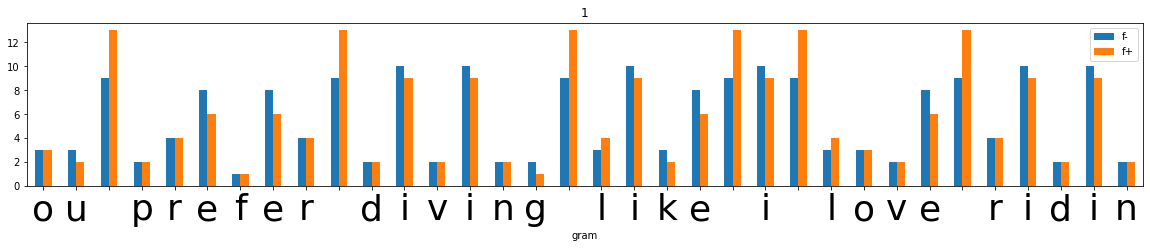

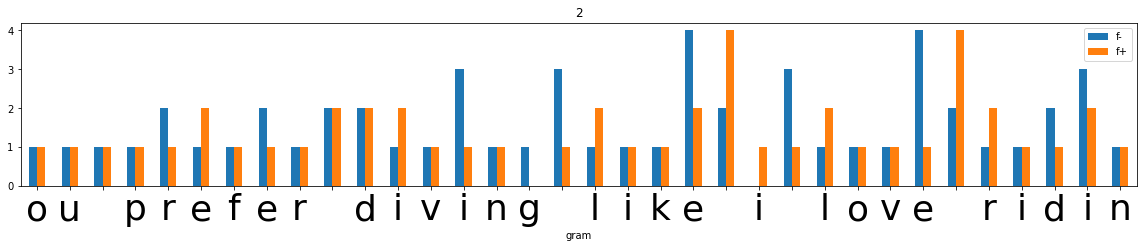

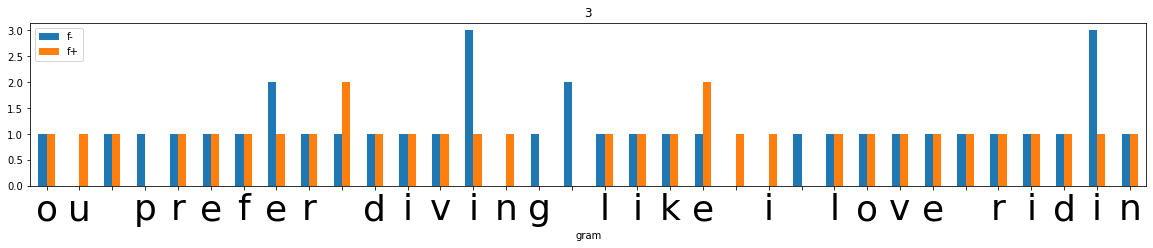

In [5]:
to = FreedomTokenizer(max_n=7,debug=False).train([
    "i like skiing","you love riding","they prefer diving",
    "he is a man","it is a table","they are humans",
    "my dog likes mean","his cat eats milk","her rabbit jumps",
])
for i in range(1,4):
    plot_bars(pd.DataFrame(profile_freedoms(to.model,"you prefer diving like i love riding",i),
                           columns=['i','gram','f+','f-']),'gram',['f-','f+'],title=str(i))


In [6]:
#freq
to.model[0]['er']

2

In [7]:
#forward
to.model[1]['er']

{' ': 2}

In [8]:
#backward
to.model[2]['er']

{'f': 1, 'h': 1}

In [9]:
# Brown Corpus
# http://www.sls.hawaii.edu/bley-vroman/brown_corpus.html
# http://www.sls.hawaii.edu/bley-vroman/brown_nolines.txt

text = url_text("http://www.sls.hawaii.edu/bley-vroman/brown_nolines.txt")
print(len(text))

19810
6006249


In [10]:
brown_to = FreedomTokenizer(max_n=7,debug=False).train([text])


In [11]:
#brown_to.store('data/models/brown_nolines_7a')
pickle.dump(brown_to.model, open('data/models/brown_nolines_7a', 'wb'), pickle.HIGHEST_PROTOCOL)
brown_to.count_params()


10967135

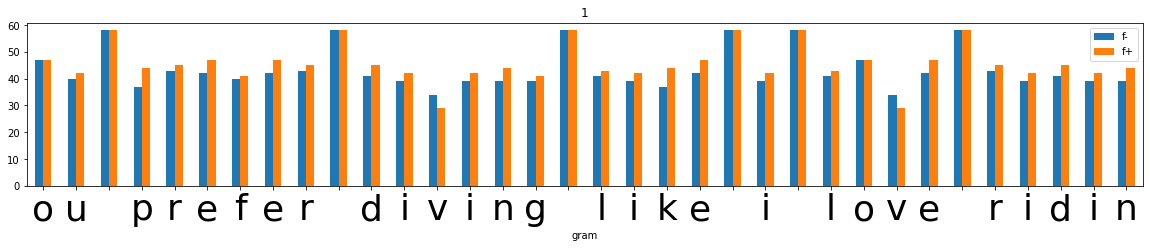

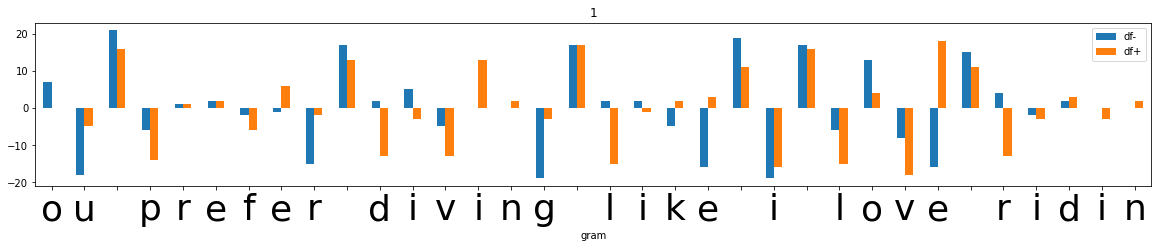

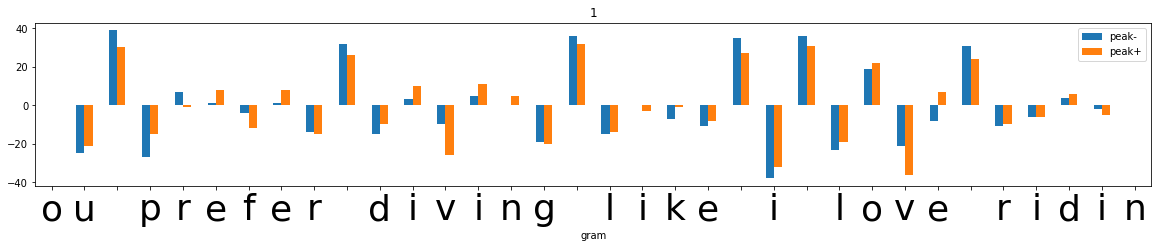

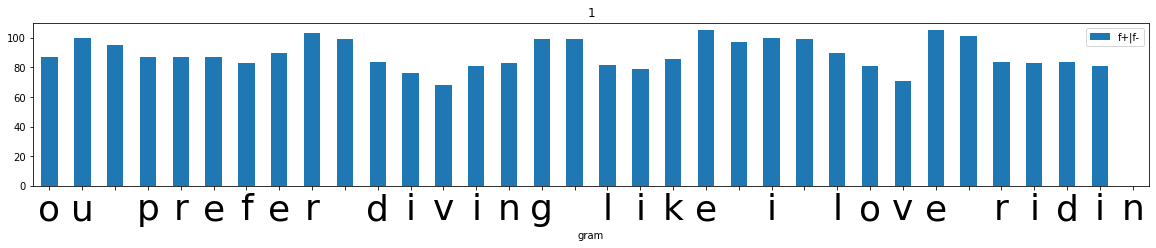

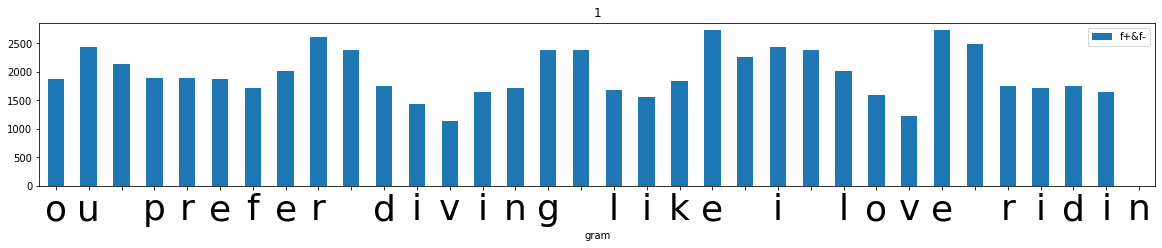

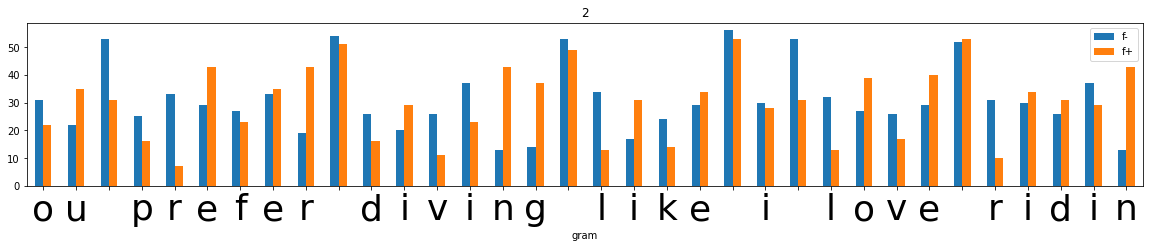

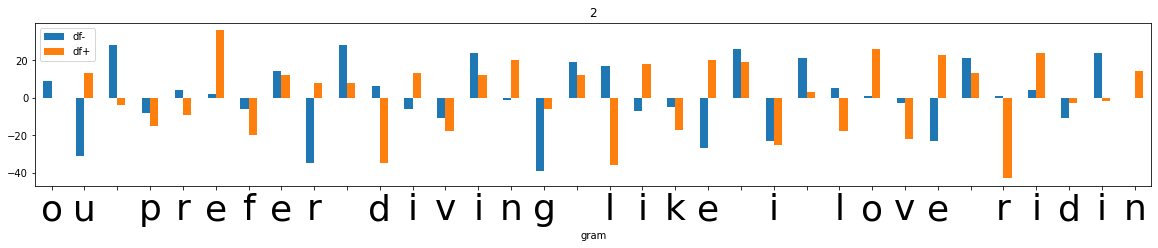

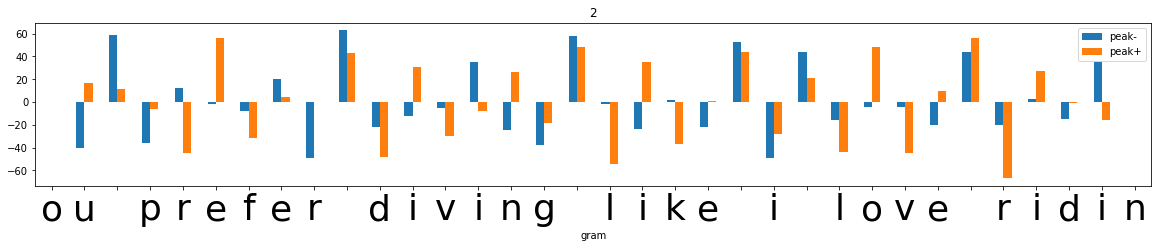

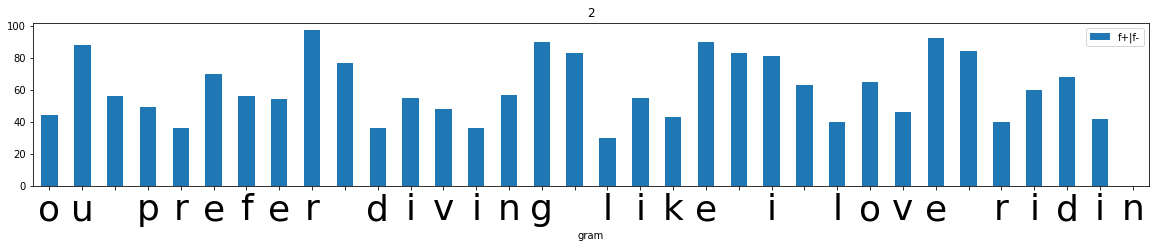

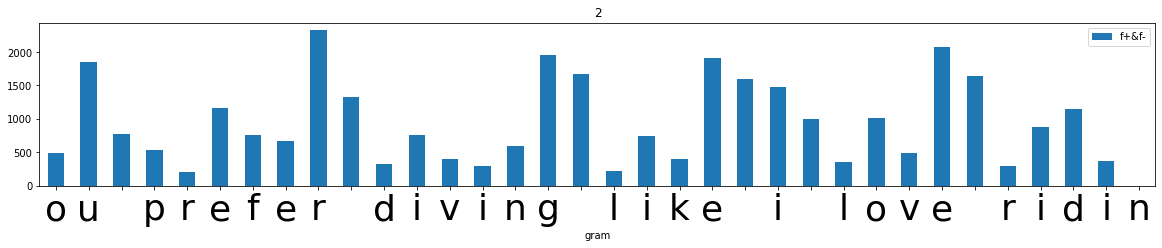

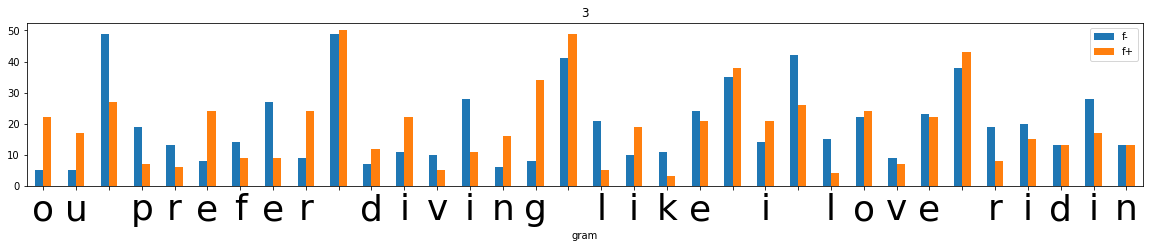

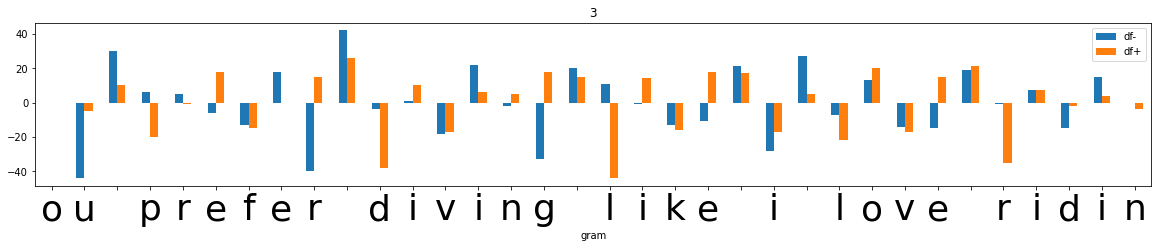

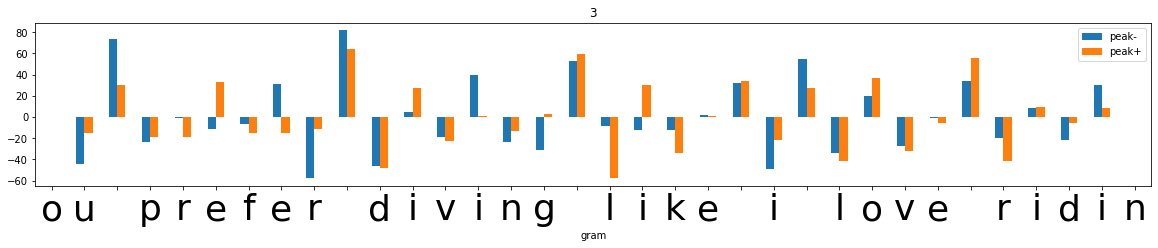

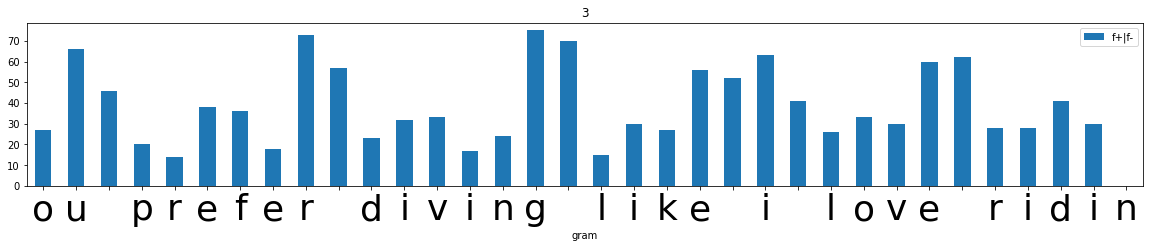

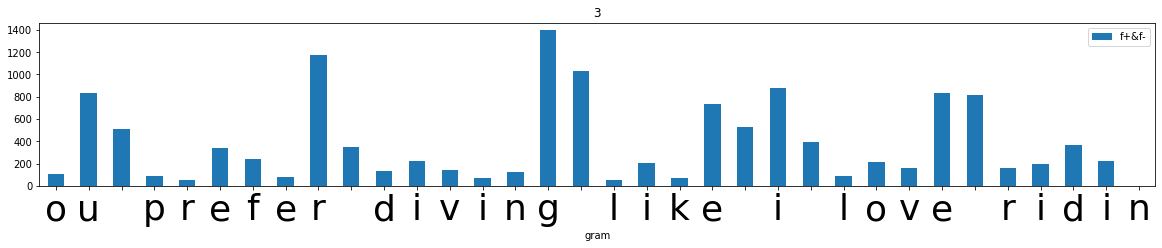

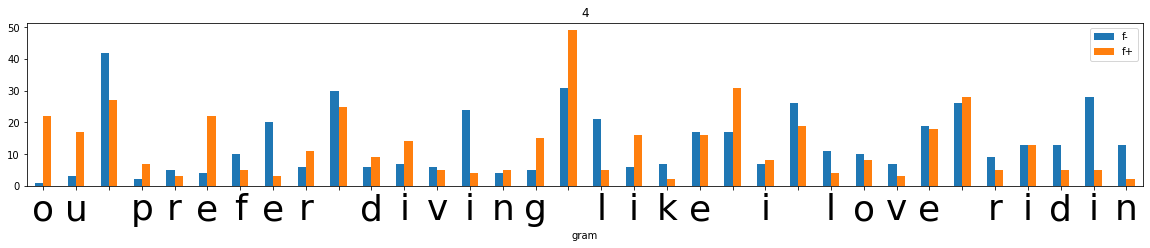

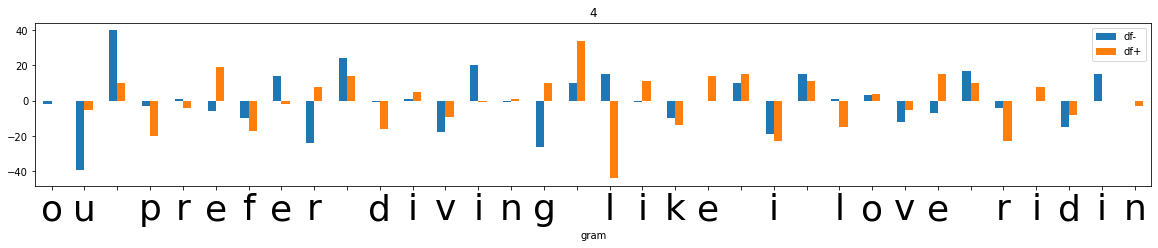

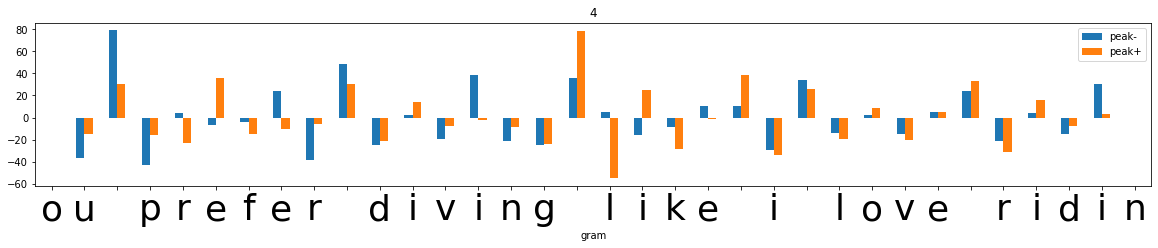

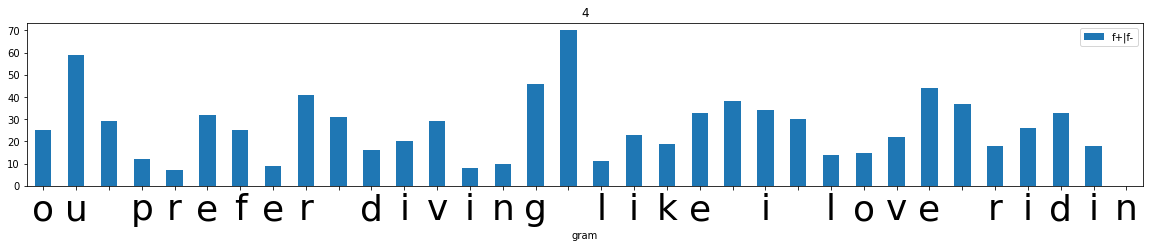

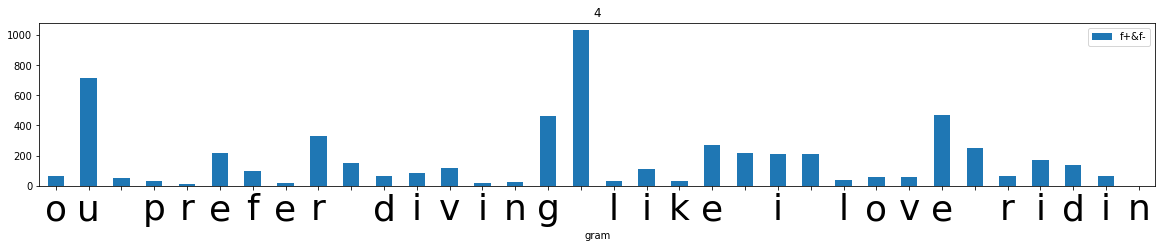

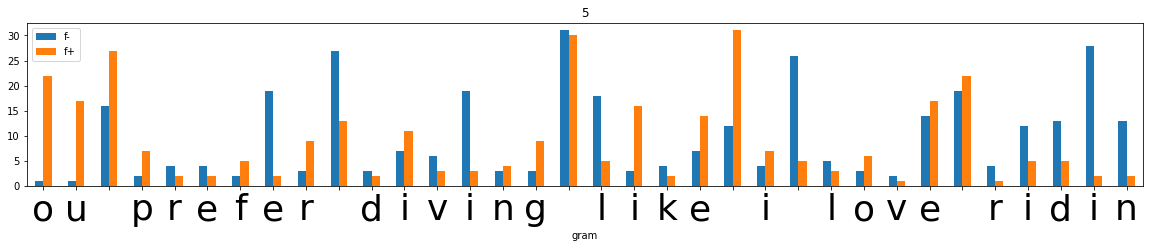

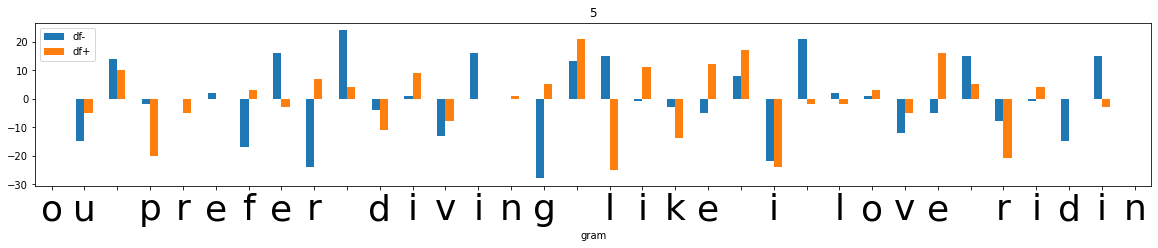

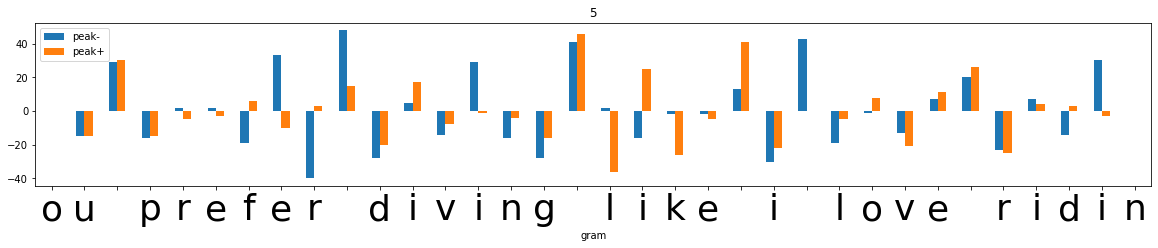

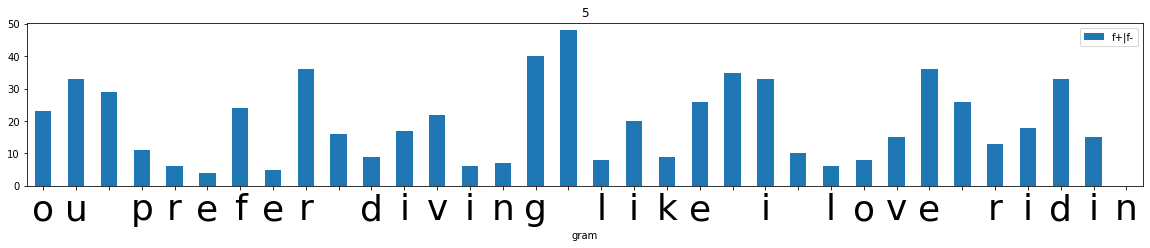

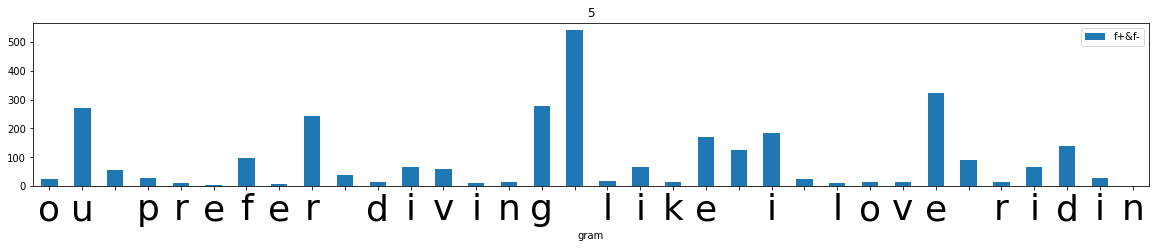

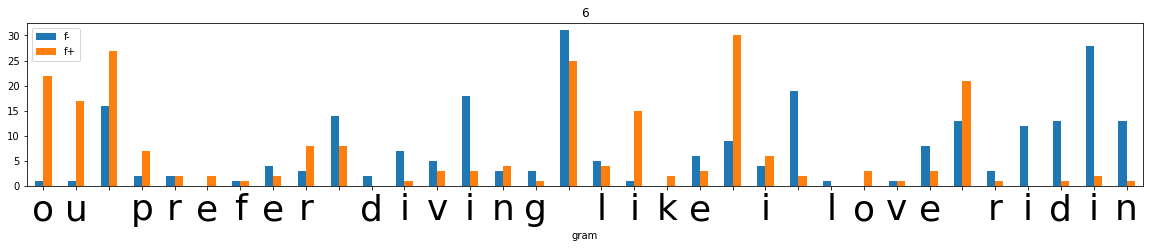

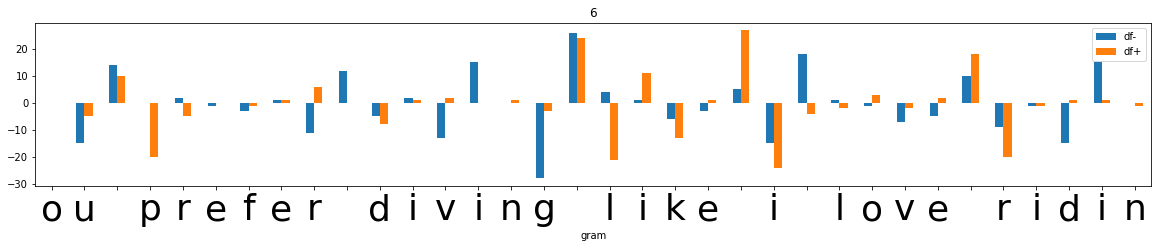

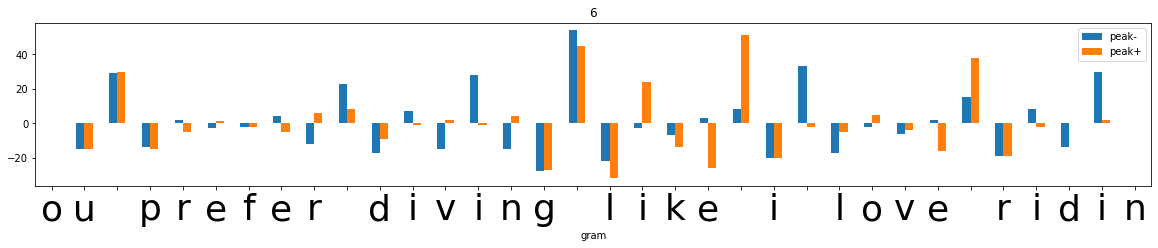

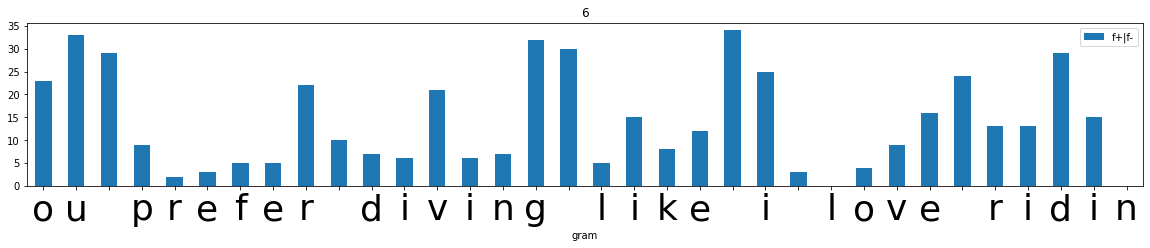

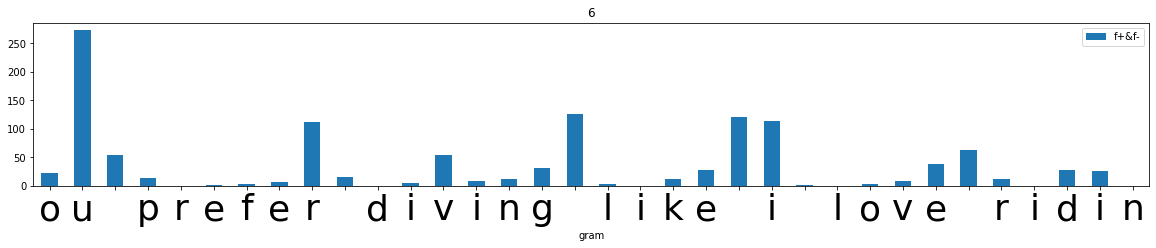

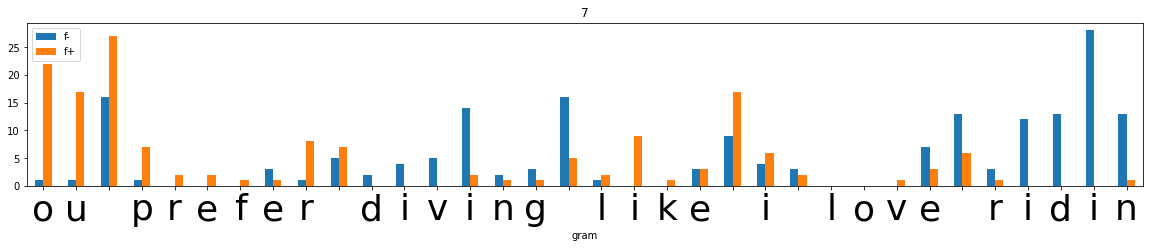

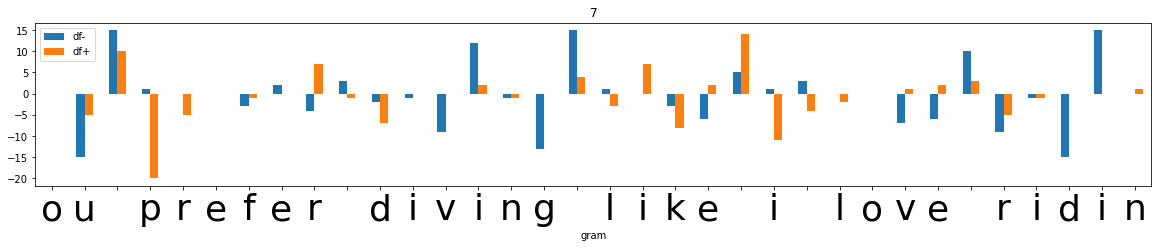

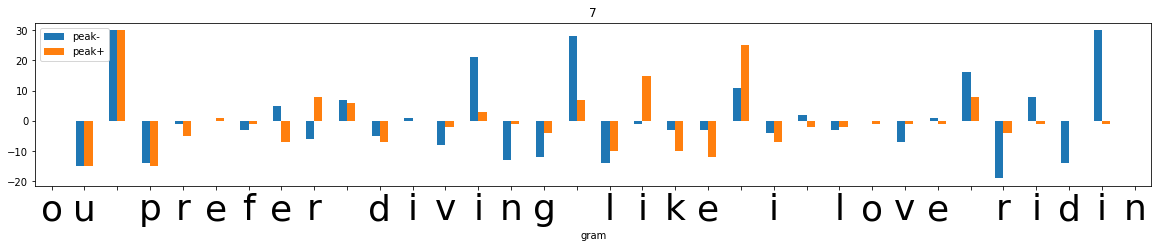

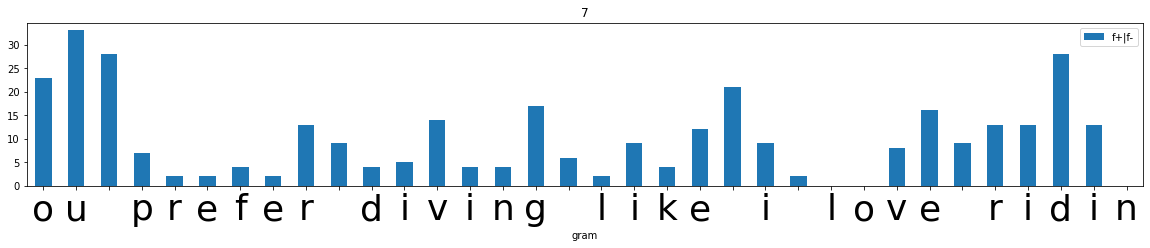

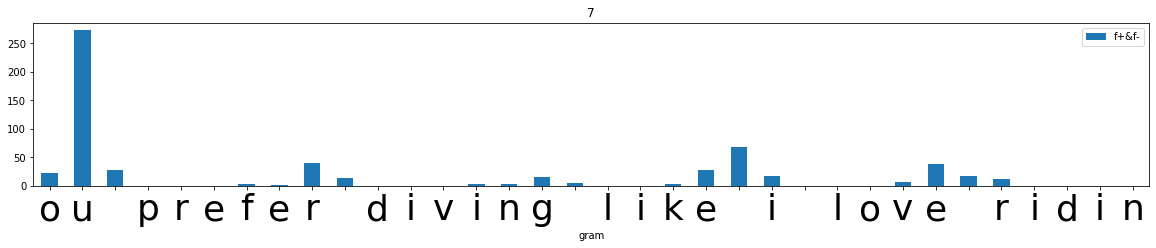

In [25]:
text = "you prefer diving like i love riding"
for i in range(1,7+1):
    df = pd.DataFrame(profile_freedoms(brown_to.model,text.lower(),i),columns=['i','gram','f+','f-'])
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    df['df+'] = df['f+'].diff() 
    df['df-'] = -df['f-'].diff().shift(-1)
    # We assigned a “peak” value to each character transition, 
    # computed by adding the value of the preceding increase in freedom to the following decrease in freedom. 
    # We characterized token boundaries based on the sum of their forward- and backward-reading peak values.
    df['peak+'] = df['df+'] - df['df+'].shift(-1)
    df['peak-'] = df['df-'] - df['df-'].shift(1)
    plot_bars(df,'gram',['df-','df+'],title=str(i))
    plot_bars(df,'gram',['peak-','peak+'],title=str(i))
    df['f+|f-'] = df['f+'] + df['f-'].shift(-1)
    df['f+&f-'] = df['f+'] * df['f-'].shift(-1)
    plot_bars(df,'gram',['f+|f-'],title=str(i))
    plot_bars(df,'gram',['f+&f-'],title=str(i))


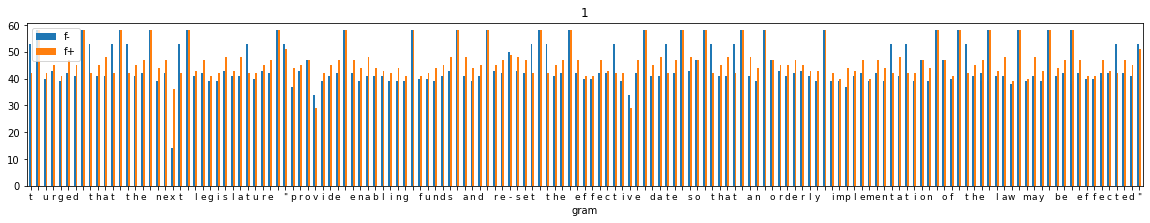

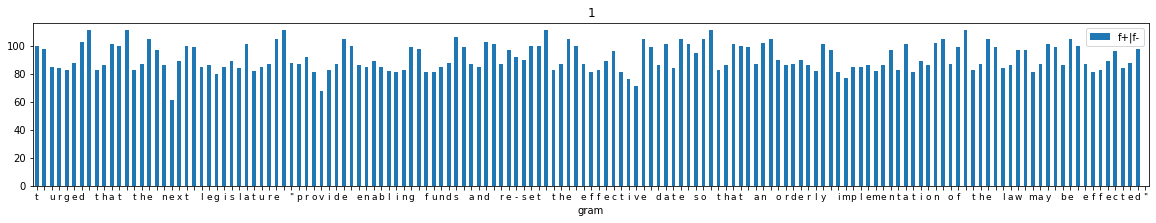

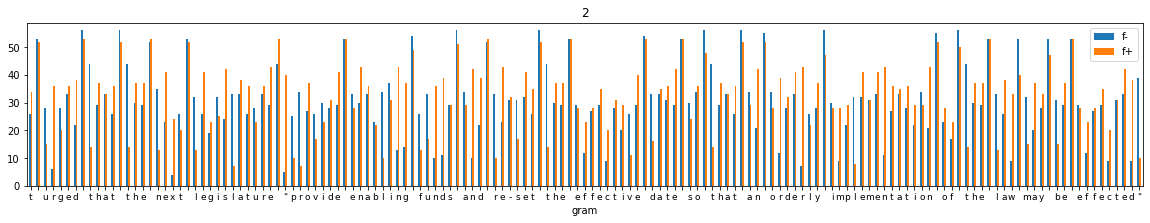

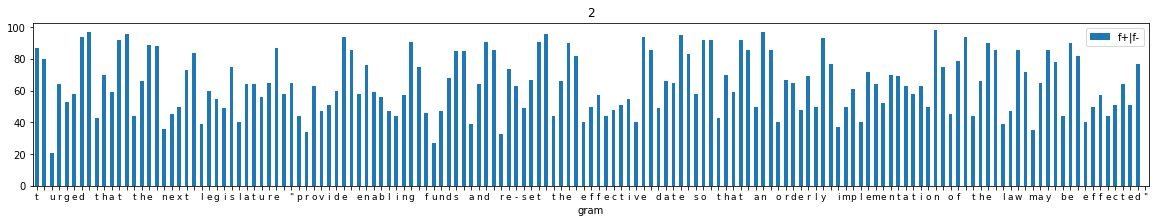

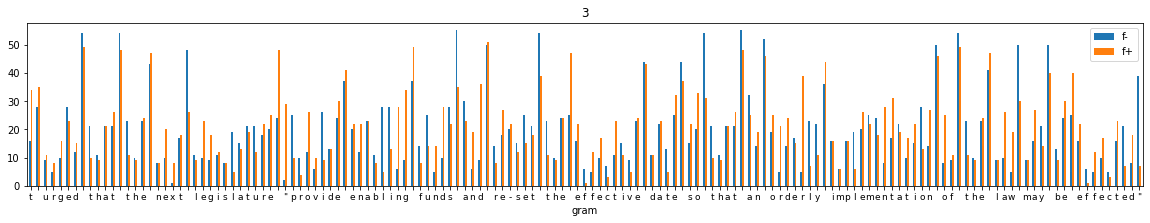

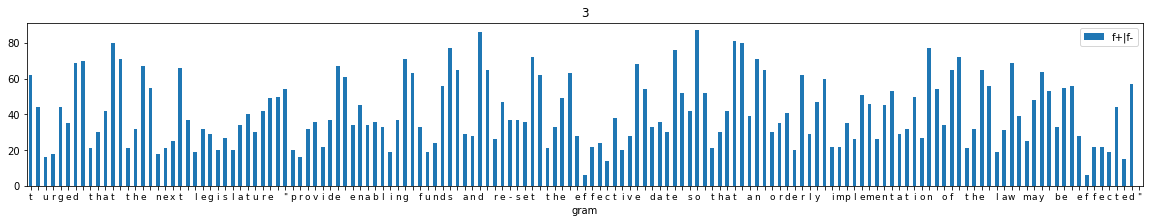

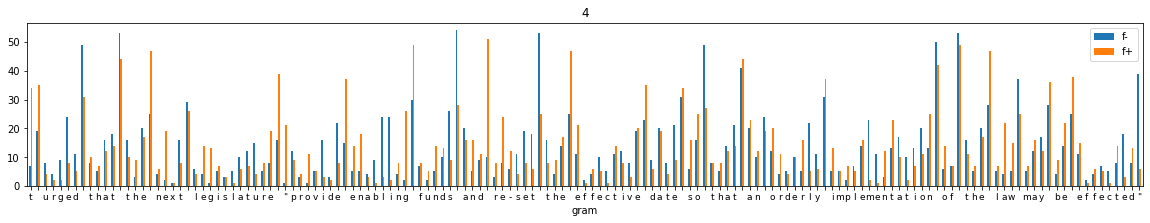

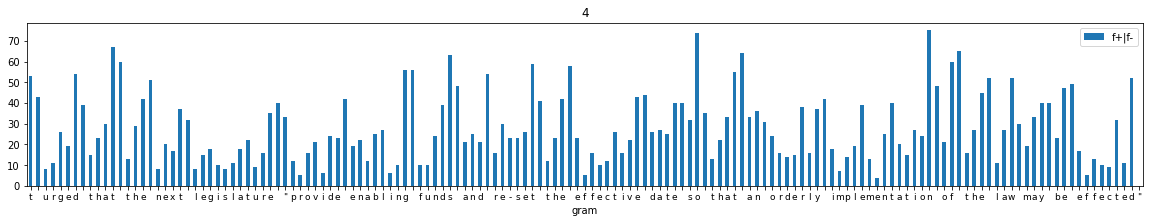

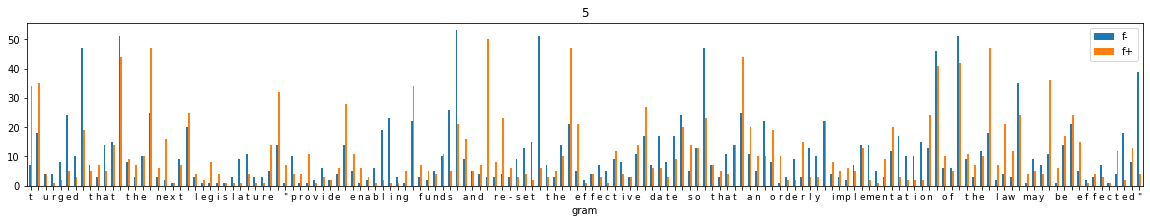

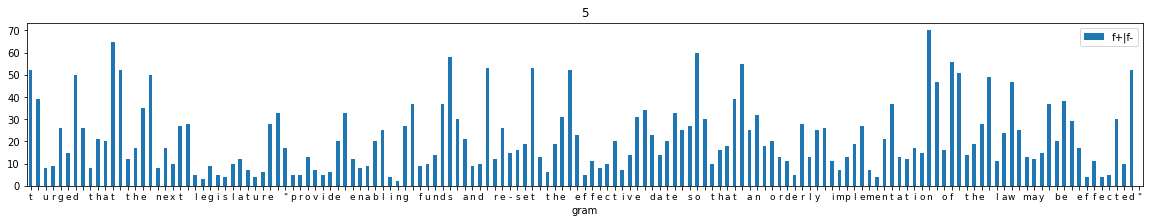

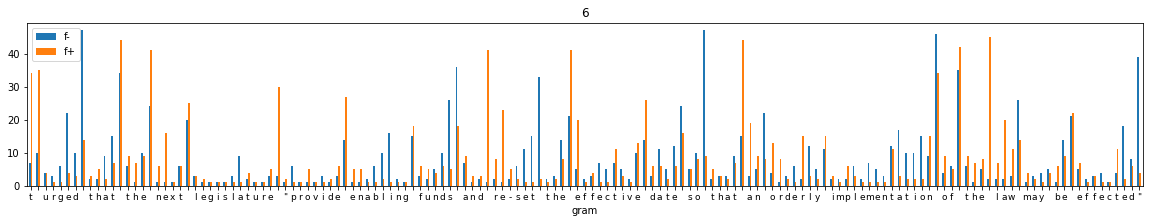

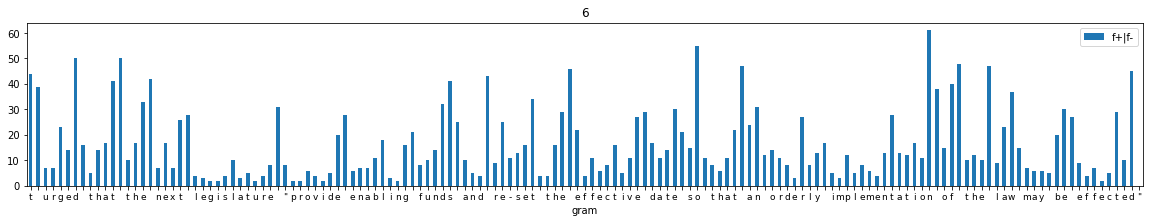

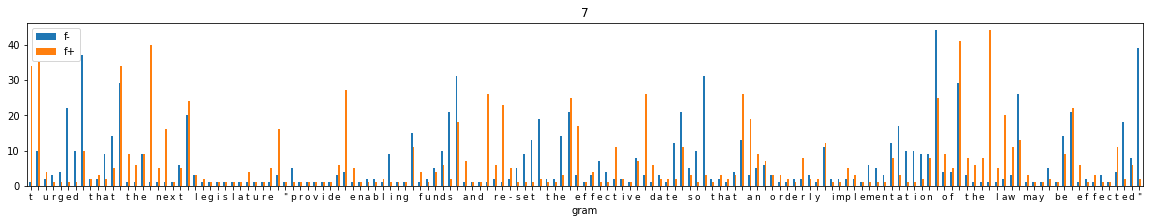

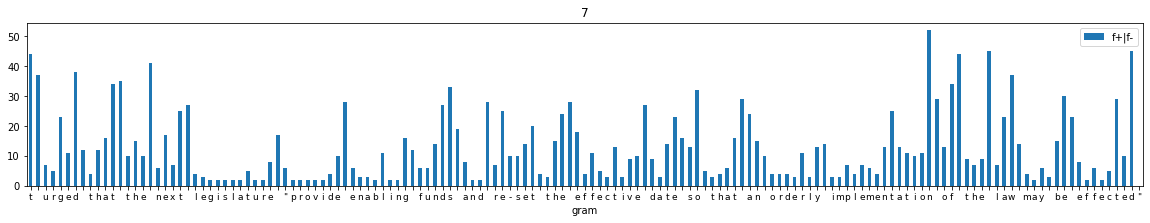

In [17]:
text = 'It urged that the next Legislature "provide enabling funds and re-set the effective date so that an orderly implementation of the law may be effected".'
for i in range(1,7+1):
    df = pd.DataFrame(profile_freedoms(brown_to.model,text.lower(),i),columns=['i','gram','f+','f-'])
    plot_bars(df,'gram',['f-','f+'],title=str(i))
    df['f+|f-'] = df['f+'] + df['f-'].shift(-1)
    df['f+*f-'] = df['f+'] * df['f-'].shift(-1)
    plot_bars(df,'gram',['f+|f-'],title=str(i))
    



In [28]:
len(brown_to.model[1]['u'])


42

In [14]:
#TODO
def perplexity(dic):
    return len(dic)

perplexity({'the':100,'a':'50','an':10,'that':2,'this':1})


5